In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [2]:
data_path = "../data_after_prep"

In [3]:
list_data = os.listdir(data_path)
list_data

['ADRO2001-2407.csv',
 'AMMN2001-2407.csv',
 'AMRT2001-2407.csv',
 'ASII2001-2407.csv',
 'BBCA2001-2407.csv',
 'GOTO2001-2407.csv',
 'KLBF2001-2407.csv',
 'MAPI2001-2407.csv',
 'TLKM2001-2407.csv']

In [4]:
ADRO = pd.read_csv(data_path + "/" + list_data[0], index_col='date', parse_dates=['date'])
AMMN = pd.read_csv(data_path + "/" + list_data[1], index_col='date', parse_dates=['date'])
AMRT = pd.read_csv(data_path + "/" + list_data[2], index_col='date', parse_dates=['date'])
ASII = pd.read_csv(data_path + "/" + list_data[3], index_col='date', parse_dates=['date'])
BBCA = pd.read_csv(data_path + "/" + list_data[4], index_col='date', parse_dates=['date'])
GOTO = pd.read_csv(data_path + "/" + list_data[5], index_col='date', parse_dates=['date'])
KLBF = pd.read_csv(data_path + "/" + list_data[6], index_col='date', parse_dates=['date'])
MAPI = pd.read_csv(data_path + "/" + list_data[7], index_col='date', parse_dates=['date'])
TLKM = pd.read_csv(data_path + "/" + list_data[8], index_col='date', parse_dates=['date'])



In [5]:
#Method
# Some functions to help out with
def plot_predictions(stock_title,test,predicted, title):
    plt.plot(test, color='red',label='Real '+ stock_title+' Stock Price')
    plt.plot(predicted, color='blue',label='Predicted '+ stock_title+' Stock Price')
    plt.title(stock_title + ' Stock Price Prediction '+title)
    plt.xlabel('Time')
    plt.ylabel(stock_title +' Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def return_rmse_norm(test, pred):
    len_pred = len(pred)
    #pred = pred.reshape(len_pred)
    total = np.concatenate((pred, test))
    #total = total.reshape(-1,1)
    total = sc.fit_transform(total)
    arr_pred = total[len_pred:]
    arr_test = total[:len_pred]
    rmse = math.sqrt(mean_squared_error(arr_test, arr_pred))
    print("The root mean squared error after normalization is {}.".format(rmse))
    return rmse

In [6]:
def short_term_train(data, name, start_date, med_date, end_date, epoch, unit, optimizer, batch_size):
    data_short_train = data[start_date:med_date].iloc[:,3:4].values
    data_short_test = data[med_date:end_date].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_short_train)
    len_train = len(data_short_train)
    len_test = len(data_short_test)
    print(len_train, len_test)

    # Since LSTMs store short term memory state, we create a data structure with 5 timesteps and 1 output
    # So for each element of training set, we have 5 previous training set elements 
    X_train = []
    y_train = []
    for i in range(5,len_train):
        X_train.append(training_set_scaled[i-5:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # The LSTM architecture
    regressorLSTM = Sequential()
    # First LSTM layer with Dropout regularisation
    regressorLSTM.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressorLSTM.add(Dropout(0.2))
    # Second LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Third LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Fourth LSTM layer
    regressorLSTM.add(LSTM(units=unit))
    regressorLSTM.add(Dropout(0.2))
    # The output layer
    regressorLSTM.add(Dense(units=1))

    # Compiling the RNN
    regressorLSTM.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set


    regressorLSTM.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)

    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=unit, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)



    # initializing the RNN
    regressorRNN = Sequential()

    # adding first RNN layer and dropout regulatization
    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True, 
                input_shape = (X_train.shape[1],1))
                )

    regressorRNN.add(
        Dropout(0.2)
                )


    # adding second RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding third RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding fourth RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding the output layer
    regressorRNN.add(Dense(units = 1))

    # compiling RNN
    regressorRNN.compile(
        optimizer = optimizer, 
        loss = "mean_squared_error",
        metrics = ["accuracy"])

    # fitting the RNN
    regressorRNN.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)


    dataset_total = pd.concat((data["close"][start_date:med_date],data["close"][med_date:end_date]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_short_test) - 5:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(5,len_test+5):
        X_test.append(inputs[i-5:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
    LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    RNN_predicted_stock_price = regressorRNN.predict(X_test)
    RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)
    # Visualize the data
    # Plot the data
    train = data[start_date:med_date]
    valid = data[med_date:end_date]
    valid['pred_lstm'] = LSTM_predicted_stock_price
    valid['pred_gru'] = GRU_predicted_stock_price
    valid['pred_rnn'] = RNN_predicted_stock_price
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM, GRU, and RNN in ' + name +' Short Term Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
    plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
    plt.savefig('../result tuning/'+name+'short_'+str(optimizer)+'_'+str(batch_size)+'_'+str(epoch)+'_'+str(unit)+'.png')
    # Evaluating the LSTM
    rmse_data_short_LSTM = return_rmse(data_short_test, LSTM_predicted_stock_price)
    norm_rmse_data_short_LSTM = return_rmse_norm(data_short_test, LSTM_predicted_stock_price)
    # Evaluating the RNN
    rmse_data_short_GRU = return_rmse(data_short_test, GRU_predicted_stock_price)
    norm_rmse_data_short_GRU = return_rmse_norm(data_short_test, GRU_predicted_stock_price)
    # Evaluating the sequence
    rmse_data_short_RNN = return_rmse(data_short_test, RNN_predicted_stock_price)
    norm_rmse_data_short_RNN = return_rmse_norm(data_short_test, RNN_predicted_stock_price)
    return(rmse_data_short_LSTM, rmse_data_short_GRU, rmse_data_short_RNN, norm_rmse_data_short_LSTM, norm_rmse_data_short_GRU, norm_rmse_data_short_RNN)



In [7]:
def long_term_train(data, name, year, epoch, unit, optimizer, batch_size):
    data_long_train = data[:year].iloc[:,3:4].values
    data_long_test = data[year:].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_long_train)
    len_train = len(data_long_train)
    len_test = len(data_long_test)
    print(len_train, len_test)

    # Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
    # So for each element of training set, we have 5 previous training set elements 
    X_train = []
    y_train = []
    for i in range(60,len_train):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # The LSTM architecture
    regressorLSTM = Sequential()
    # First LSTM layer with Dropout regularisation
    regressorLSTM.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressorLSTM.add(Dropout(0.2))
    # Second LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Third LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Fourth LSTM layer
    regressorLSTM.add(LSTM(units=unit))
    regressorLSTM.add(Dropout(0.2))
    # The output layer
    regressorLSTM.add(Dense(units=1))

    # Compiling the RNN
    regressorLSTM.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set


    regressorLSTM.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)

    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=unit, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)



    # initializing the RNN
    regressorRNN = Sequential()

    # adding first RNN layer and dropout regulatization
    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True, 
                input_shape = (X_train.shape[1],1))
                )

    regressorRNN.add(
        Dropout(0.2)
                )


    # adding second RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding third RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding fourth RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding the output layer
    regressorRNN.add(Dense(units = 1))

    # compiling RNN
    regressorRNN.compile(
        optimizer = optimizer, 
        loss = "mean_squared_error",
        metrics = ["accuracy"])

    # fitting the RNN
    regressorRNN.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)


    dataset_total = pd.concat((data["close"][:year],data["close"][year:]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_long_test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(60,len_test+60):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
    LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    RNN_predicted_stock_price = regressorRNN.predict(X_test)
    RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

    # Visualize the data
    # Plot the data
    train = data[:year]
    valid = data[year:]
    valid['pred_lstm'] = LSTM_predicted_stock_price
    valid['pred_gru'] = GRU_predicted_stock_price
    valid['pred_rnn'] = RNN_predicted_stock_price
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM, GRU, and RNN in ' + name +' Long Term Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
    plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
    plt.savefig('../result tuning/'+name+'long_'+str(optimizer)+'_'+str(batch_size)+'_'+str(epoch)+'_'+str(unit)+'.png')
    # Evaluating the LSTM
    rmse_data_long_LSTM = return_rmse(data_long_test, LSTM_predicted_stock_price)
    norm_rmse_data_long_LSTM = return_rmse_norm(data_long_test, LSTM_predicted_stock_price)
    # Evaluating the RNN
    rmse_data_long_GRU = return_rmse(data_long_test, GRU_predicted_stock_price)
    norm_rmse_data_long_GRU = return_rmse_norm(data_long_test, GRU_predicted_stock_price)
    # Evaluating the sequence
    rmse_data_long_RNN = return_rmse(data_long_test, RNN_predicted_stock_price)
    norm_rmse_data_long_RNN = return_rmse_norm(data_long_test, RNN_predicted_stock_price)
    return(rmse_data_long_LSTM, rmse_data_long_GRU, rmse_data_long_RNN, norm_rmse_data_long_LSTM, norm_rmse_data_long_GRU, norm_rmse_data_long_RNN)



In [8]:
dic_res = {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : []}

In [9]:
#short term data
start_date = "2024-07-01"
med_date = "2024-07-19"
end_date = "2024-07-31"

#long term data
year = "2023"

## Benchmark Hyperparameter
Architecutre of LSTM, GRU, and RNN used is in this code bechmark from this source:
- LSTM: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook
- GRU: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook
- RNN: https://www.kaggle.com/code/ozkanozturk/stock-price-prediction-by-simple-rnn-and-lstm

### ASII

#### Short Term Predictions

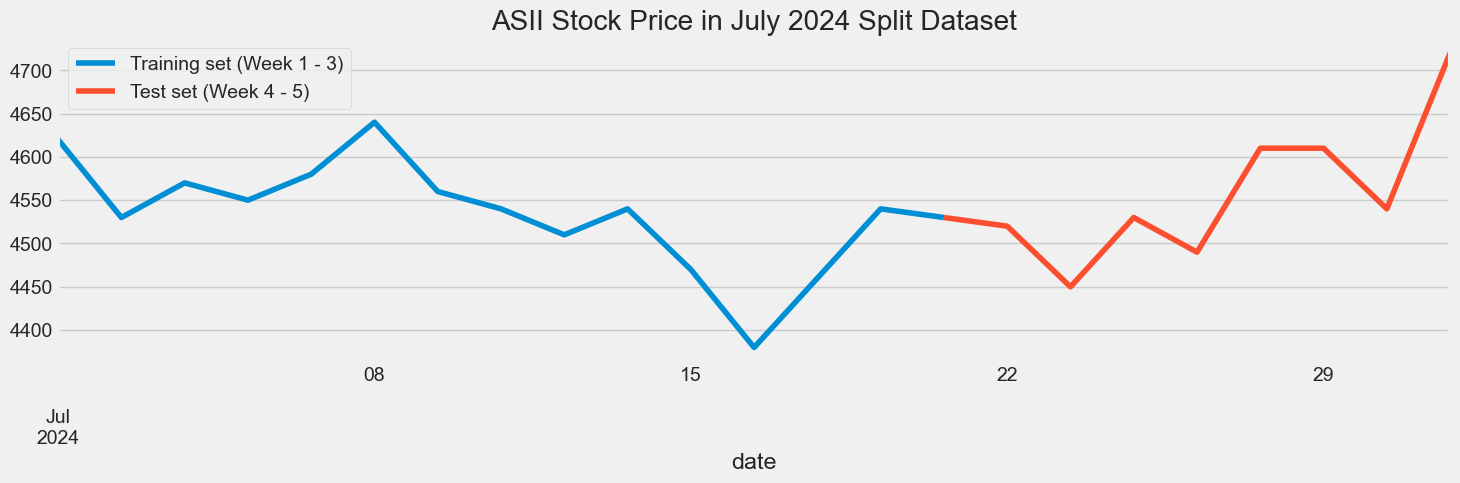

In [11]:
ASII["close"][start_date:med_date].plot(figsize=(16,4), legend=True)
ASII["close"][med_date:end_date].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('ASII Stock Price in July 2024 Split Dataset')
plt.show()

In [12]:
ASII_short_train = ASII[start_date:med_date].iloc[:,3:4].values
ASII_short_test = ASII[med_date:end_date].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ASII_short_train)
len_train = len(ASII_short_train)
len_test = len(ASII_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((ASII["close"][start_date:med_date],ASII["close"][med_date:end_date]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ASII_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(5,len_test+5):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


15 9


Epoch 1/50

1/1 [==============================] - 19s 19s/step - loss: 0.4015
Epoch 2/50
1/1 [==============================] - 0s 98ms/step - loss: 0.3647
Epoch 3/50
1/1 [==============================] - 0s 154ms/step - loss: 0.3354
Epoch 4/50
1/1 [==============================] - 0s 91ms/step - loss: 0.3092
Epoch 5/50
1/1 [==============================] - 0s 89ms/step - loss: 0.2748
Epoch 6/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2368
Epoch 7/50
1/1 [==============================] - 0s 49ms/step - loss: 0.2042
Epoch 8/50
1/1 [==============================] - 0s 38ms/step - loss: 0.1561
Epoch 9/50
1/1 [==============================] - 0s 79ms/step - loss: 0.1383
Epoch 10/50
1/1 [==============================] - 0s 51ms/step - loss: 0.1135
Epoch 11/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0974
Epoch 12/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0640
Epoch 13/50
1/1 [==============================] - 0

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

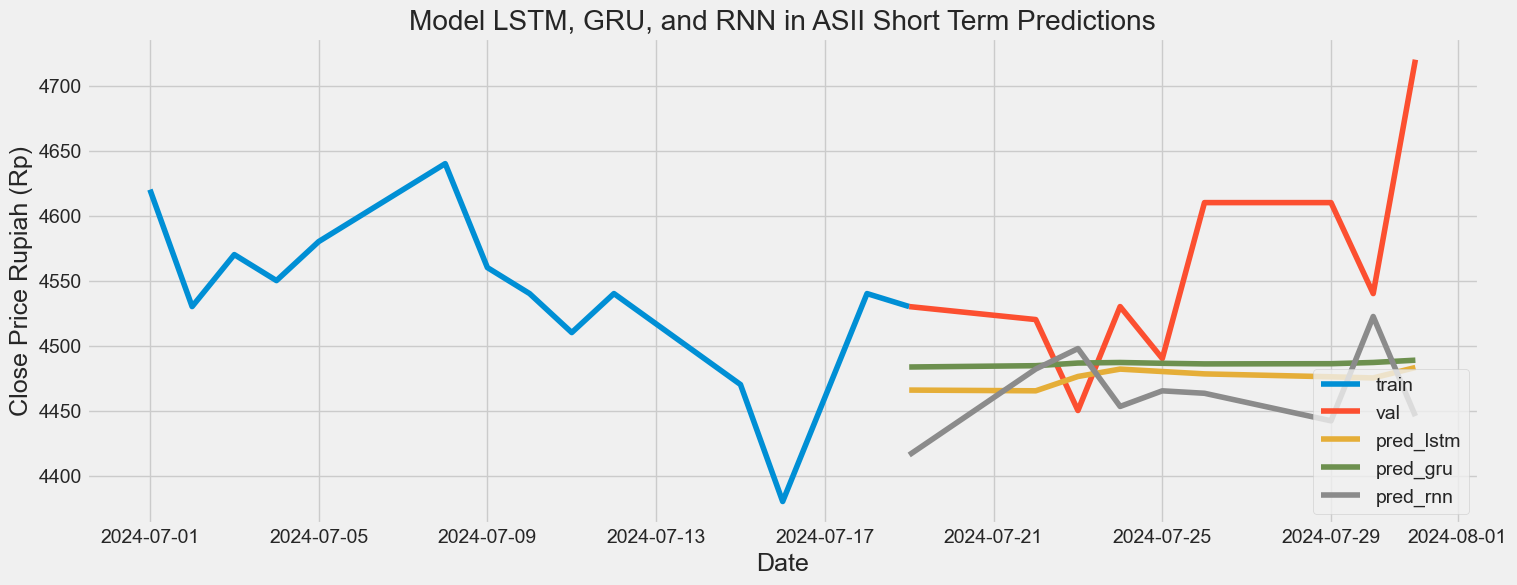

In [13]:
# Visualize the data
# Plot the data
train = ASII[start_date:med_date]
valid = ASII[med_date:end_date]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in ASII Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


In [14]:
# Evaluating the LSTM
rmse_ASII_short_LSTM = return_rmse(ASII_short_test, LSTM_predicted_stock_price)
norm_rmse_ASII_short_LSTM = return_rmse_norm(ASII_short_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_ASII_short_GRU = return_rmse(ASII_short_test, GRU_predicted_stock_price)
norm_rmse_ASII_short_GRU = return_rmse_norm(ASII_short_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_ASII_short_RNN = return_rmse(ASII_short_test, RNN_predicted_stock_price)
norm_rmse_ASII_short_RNN = return_rmse_norm(ASII_short_test, RNN_predicted_stock_price)


The root mean squared error is 55.00948728414271.
The root mean squared error after normalization is 0.39292490917244854.
The root mean squared error is 51.41078512509552.
The root mean squared error after normalization is 0.36721989375068265.
The root mean squared error is 72.92394184766954.
The root mean squared error after normalization is 0.4186496333556479.


In [15]:
#add to the table
#add result LSTM for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_ASII_short_LSTM)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_LSTM)

#add result GRU for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_ASII_short_GRU)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_GRU)

#add result RNN for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_ASII_short_RNN)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_RNN)

In [16]:
dic_res

{'stock': ['ASII', 'ASII', 'ASII'],
 'term': ['short', 'short', 'short'],
 'algorithm': ['LSTM', 'GRU', 'RNN'],
 'rmse': [55.00948728414271, 51.41078512509552, 72.92394184766954],
 'rmse_norm': [0.39292490917244854, 0.36721989375068265, 0.4186496333556479]}

#### Long Term Prediction

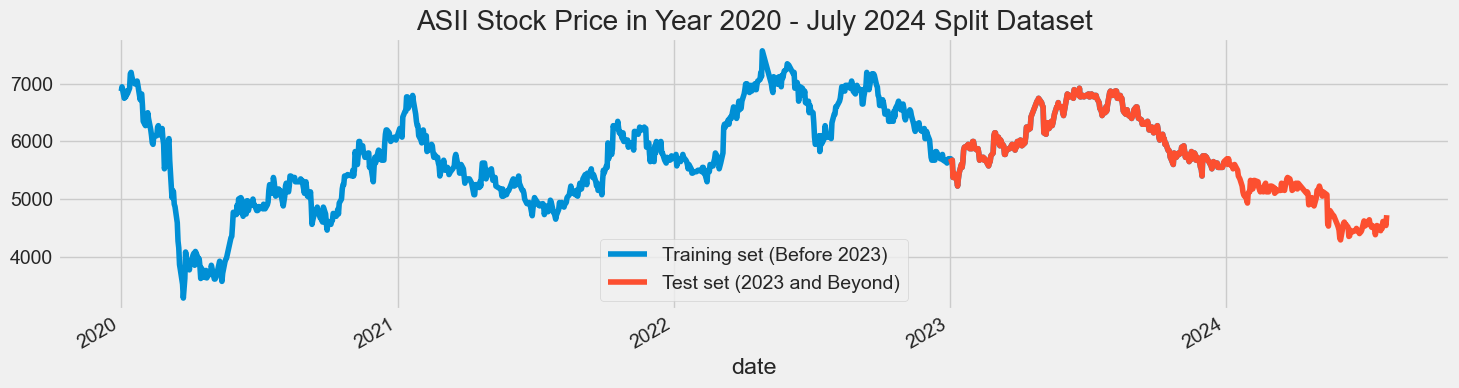

In [17]:
ASII["close"][:year].plot(figsize=(16,4), legend=True)
ASII["close"][year:].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Before 2023)","Test set (2023 and Beyond)"])
plt.title('ASII Stock Price in Year 2020 - July 2024 Split Dataset')
plt.show()

In [18]:
ASII_long_train = ASII[:year].iloc[:,3:4].values
ASII_long_test = ASII[year:].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ASII_long_train)
len_train = len(ASII_long_train)
len_test = len(ASII_long_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((ASII["close"][:year],ASII["close"][year:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ASII_long_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len_test+60):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


974 372
Epoch 1/50
29/29 [==============================] - 29s 141ms/step - loss: 0.0495
Epoch 2/50
29/29 [==============================] - 4s 129ms/step - loss: 0.0213
Epoch 3/50
29/29 [==============================] - 5s 189ms/step - loss: 0.0181
Epoch 4/50
29/29 [==============================] - 5s 180ms/step - loss: 0.0178
Epoch 5/50
29/29 [==============================] - 6s 220ms/step - loss: 0.0132
Epoch 6/50
29/29 [==============================] - 4s 155ms/step - loss: 0.0170
Epoch 7/50
29/29 [==============================] - 4s 121ms/step - loss: 0.0123
Epoch 8/50
29/29 [==============================] - 4s 154ms/step - loss: 0.0127
Epoch 9/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0120
Epoch 10/50
29/29 [==============================] - 8s 282ms/step - loss: 0.0118
Epoch 11/50
29/29 [==============================] - 4s 132ms/step - loss: 0.0108
Epoch 12/50
29/29 [==============================] - 4s 126ms/step - loss: 0.0093
Epoch 13/50
29/2

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

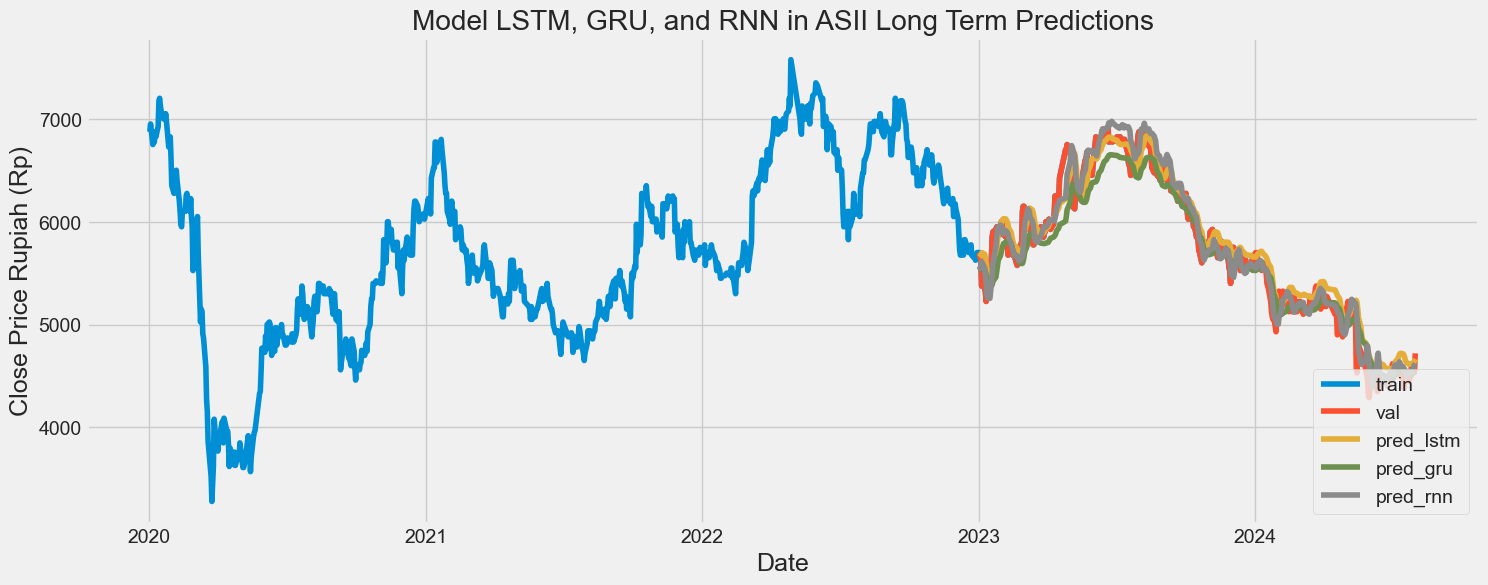

In [19]:
# Visualize the data
# Plot the data
train = ASII[:year]
valid = ASII[year:]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in ASII Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


In [20]:
# Evaluating the LSTM
rmse_ASII_long_LSTM = return_rmse(ASII_long_test, LSTM_predicted_stock_price)
norm_rmse_ASII_long_LSTM = return_rmse_norm(ASII_long_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_ASII_long_GRU = return_rmse(ASII_long_test, GRU_predicted_stock_price)
norm_rmse_ASII_long_GRU = return_rmse_norm(ASII_long_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_ASII_long_RNN = return_rmse(ASII_long_test, RNN_predicted_stock_price)
norm_rmse_ASII_long_RNN = return_rmse_norm(ASII_long_test, RNN_predicted_stock_price)


The root mean squared error is 197.5755217333279.
The root mean squared error after normalization is 0.07762084459241526.
The root mean squared error is 167.37215284412167.
The root mean squared error after normalization is 0.06602451788722748.
The root mean squared error is 163.07260452597404.
The root mean squared error after normalization is 0.06070873133266466.


In [21]:
#add to the table
#add result LSTM for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_ASII_long_LSTM)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_LSTM)

#add result GRU for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_ASII_long_GRU)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_GRU)

#add result RNN for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_ASII_long_RNN)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_RNN)

### GOTO

#### Short Term Predictions

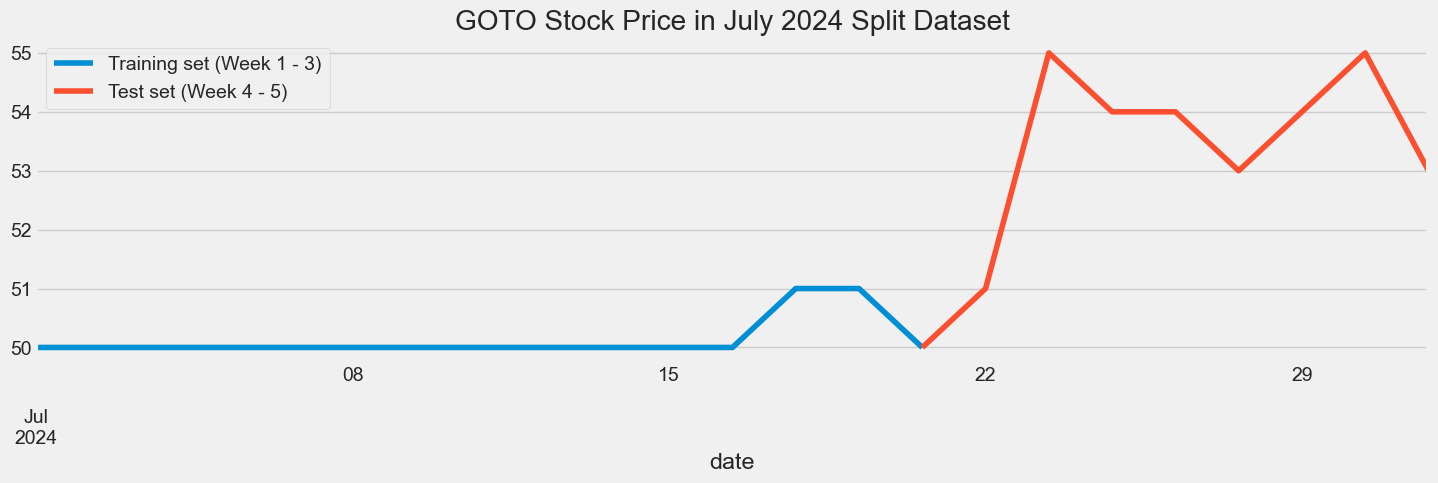

In [22]:
GOTO["close"][start_date:med_date].plot(figsize=(16,4), legend=True)
GOTO["close"][med_date:end_date].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('GOTO Stock Price in July 2024 Split Dataset')
plt.show()

In [23]:
GOTO_short_train = GOTO[start_date:med_date].iloc[:,3:4].values
GOTO_short_test = GOTO[med_date:end_date].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(GOTO_short_train)
len_train = len(GOTO_short_train)
len_test = len(GOTO_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((GOTO["close"][start_date:med_date],GOTO["close"][med_date:end_date]),axis=0)
inputs = dataset_total[len(dataset_total)-len(GOTO_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(5,len_test+5):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


15 9
Epoch 1/50
1/1 [==============================] - 19s 19s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 13

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

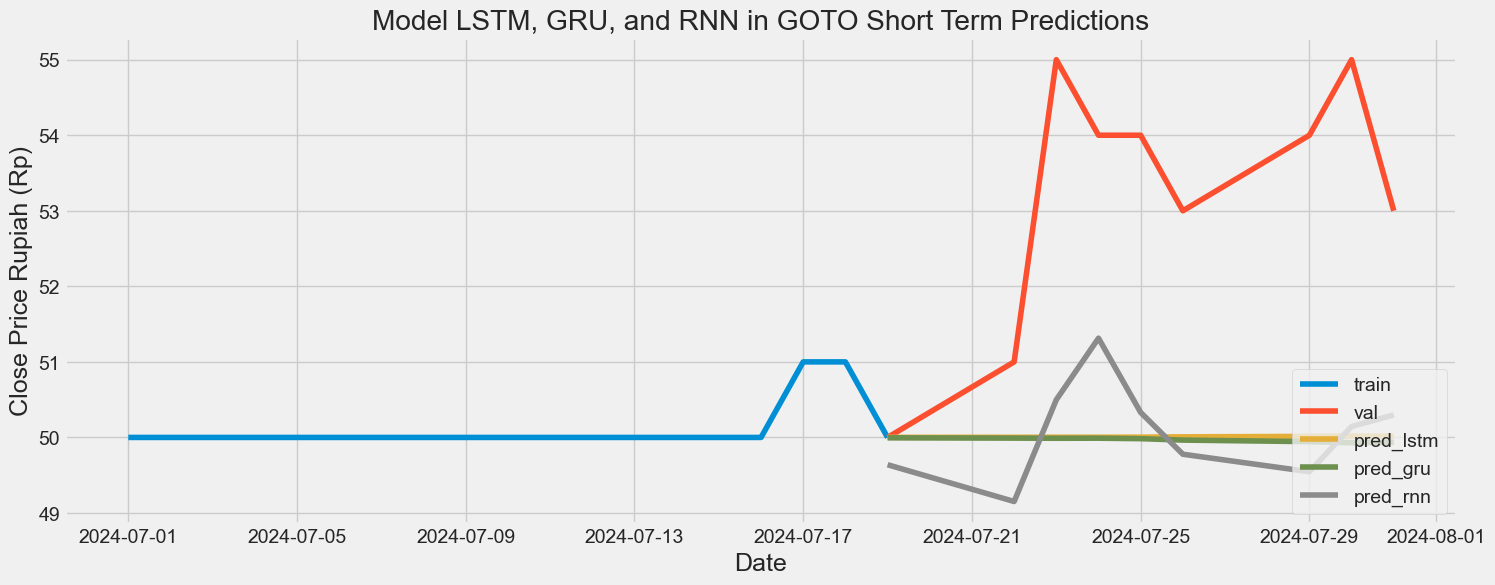

In [24]:
# Visualize the data
# Plot the data
train = GOTO[start_date:med_date]
valid = GOTO[med_date:end_date]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in GOTO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


In [25]:
# Evaluating the LSTM
rmse_GOTO_short_LSTM = return_rmse(GOTO_short_test, LSTM_predicted_stock_price)
norm_rmse_GOTO_short_LSTM = return_rmse_norm(GOTO_short_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_GOTO_short_GRU = return_rmse(GOTO_short_test, GRU_predicted_stock_price)
norm_rmse_GOTO_short_GRU = return_rmse_norm(GOTO_short_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_GOTO_short_RNN = return_rmse(GOTO_short_test, RNN_predicted_stock_price)
norm_rmse_GOTO_short_RNN = return_rmse_norm(GOTO_short_test, RNN_predicted_stock_price)


The root mean squared error is 2.3485607668839226.
The root mean squared error after normalization is 0.7828535889613071.
The root mean squared error is 2.3901321579925154.
The root mean squared error after normalization is 0.7785089621701156.
The root mean squared error is 2.2216644652497815.
The root mean squared error after normalization is 0.5773929000990808.


In [26]:
#add to the table
#add result LSTM for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_GOTO_short_LSTM)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_LSTM)

#add result GRU for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_GOTO_short_GRU)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_GRU)

#add result RNN for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_GOTO_short_RNN)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_RNN)

#### Long Term Predictions

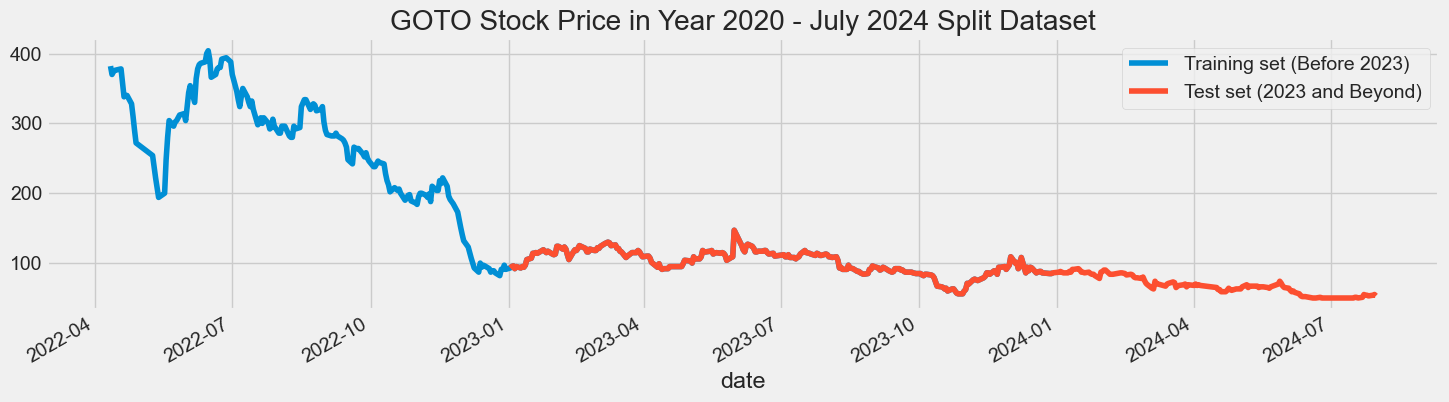

In [27]:
GOTO["close"][:year].plot(figsize=(16,4), legend=True)
GOTO["close"][year:].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Before 2023)","Test set (2023 and Beyond)"])
plt.title('GOTO Stock Price in Year 2020 - July 2024 Split Dataset')
plt.show()

In [28]:
GOTO_long_train = GOTO[:year].iloc[:,3:4].values
GOTO_long_test = GOTO[year:].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(GOTO_long_train)
len_train = len(GOTO_long_train)
len_test = len(GOTO_long_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((GOTO["close"][:year],GOTO["close"][year:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(GOTO_long_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len_test+60):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


418 372
Epoch 1/50
12/12 [==============================] - 16s 97ms/step - loss: 0.0213
Epoch 2/50
12/12 [==============================] - 1s 112ms/step - loss: 0.0103
Epoch 3/50
12/12 [==============================] - 1s 115ms/step - loss: 0.0066
Epoch 4/50
12/12 [==============================] - 1s 111ms/step - loss: 0.0098
Epoch 5/50
12/12 [==============================] - 2s 153ms/step - loss: 0.0093
Epoch 6/50
12/12 [==============================] - 2s 193ms/step - loss: 0.0064
Epoch 7/50
12/12 [==============================] - 2s 126ms/step - loss: 0.0076
Epoch 8/50
12/12 [==============================] - 1s 121ms/step - loss: 0.0059
Epoch 9/50
12/12 [==============================] - 2s 156ms/step - loss: 0.0071
Epoch 10/50
12/12 [==============================] - 4s 301ms/step - loss: 0.0045
Epoch 11/50
12/12 [==============================] - 2s 205ms/step - loss: 0.0053
Epoch 12/50
12/12 [==============================] - 1s 104ms/step - loss: 0.0071
Epoch 13/50
12/12

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

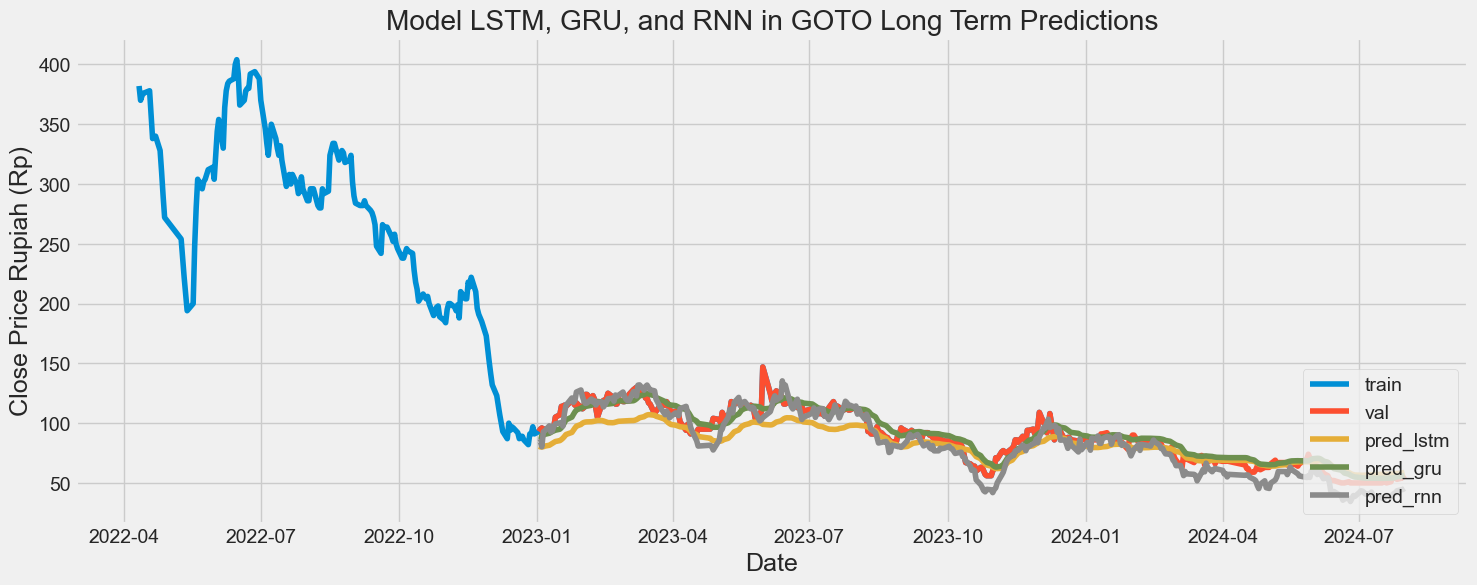

In [29]:
# Visualize the data
# Plot the data
train = GOTO[:year]
valid = GOTO[year:]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in GOTO Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


In [30]:
# Evaluating the LSTM
rmse_GOTO_long_LSTM = return_rmse(GOTO_long_test, LSTM_predicted_stock_price)
norm_rmse_GOTO_long_LSTM = return_rmse_norm(GOTO_long_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_GOTO_long_GRU = return_rmse(GOTO_long_test, GRU_predicted_stock_price)
norm_rmse_GOTO_long_GRU = return_rmse_norm(GOTO_long_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_GOTO_long_RNN = return_rmse(GOTO_long_test, RNN_predicted_stock_price)
norm_rmse_GOTO_long_RNN = return_rmse_norm(GOTO_long_test, RNN_predicted_stock_price)


The root mean squared error is 10.179641512203748.
The root mean squared error after normalization is 0.13050822451543267.
The root mean squared error is 7.381589976016897.
The root mean squared error after normalization is 0.09463576892329355.
The root mean squared error is 8.10699611494832.
The root mean squared error after normalization is 0.08033623230537396.


In [31]:
#add to the table
#add result LSTM for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_GOTO_long_LSTM)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_LSTM)

#add result GRU for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_GOTO_long_GRU)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_GRU)

#add result RNN for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_GOTO_long_RNN)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_RNN)

In [32]:
res = pd.DataFrame(dic_res)

In [45]:
res['epoch'] = 50
res['unit'] = 50
res['optimizer'] = ['rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam']
res['batch_size'] = [32, 150, 32, 32, 150, 32, 32, 150, 32, 32, 150, 32]

In [46]:
res

,stock,term,algorithm,rmse,rmse_norm,epoch,unit,optimizer,batch_size
0,ASII,short,LSTM,55.009487,0.392925,50,50,rmsprop,32
1,ASII,short,GRU,51.410785,0.367220,50,50,sgd,150
2,ASII,short,RNN,72.923942,0.418650,50,50,adam,32
3,ASII,long,LSTM,197.575522,0.077621,50,50,rmsprop,32
4,ASII,long,GRU,167.372153,0.066025,50,50,sgd,150
5,ASII,long,RNN,163.072605,0.060709,50,50,adam,32
6,GOTO,short,LSTM,2.348561,0.782854,50,50,rmsprop,32
7,GOTO,short,GRU,2.390132,0.778509,50,50,sgd,150
8,GOTO,short,RNN,2.221664,0.577393,50,50,adam,32
9,GOTO,long,LSTM,10.179642,0.130508,50,50,rmsprop,32


In [47]:
res.to_csv('../result/goto-asii-long-short-baseline.csv')

## Tuning Hyperparameter
- optimizer = SGD, Adam, RMSProp
- epoch = 50, 100
- batch size =  32, 64, 128
- unit = 50, 100


#### Short Term Predictions

In [18]:
dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}

In [23]:
def train_short(data, name, start_date, med_date, end_date, epoch, unit, batch_size, optimizer):
    rmse_LSTM, rmse_GRU, rmse_RNN, rmse_norm_LSTM, rmse_norm_GRU, rmse_norm_RNN =  short_term_train(data=data, name=name, start_date=start_date, med_date=med_date, end_date=end_date, epoch=epoch, unit=unit, batch_size=batch_size, optimizer= optimizer) 
    dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}
    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)

    dic_res_tuning['algorithm'].append('LSTM')
    dic_res_tuning['rmse'].append(rmse_LSTM)
    dic_res_tuning['rmse_norm'].append(rmse_norm_LSTM)

    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)

    dic_res_tuning['algorithm'].append('GRU')
    dic_res_tuning['rmse'].append(rmse_GRU)
    dic_res_tuning['rmse_norm'].append(rmse_norm_GRU)


    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)
    
    dic_res_tuning['algorithm'].append('RNN')
    dic_res_tuning['rmse'].append(rmse_RNN)
    dic_res_tuning['rmse_norm'].append(rmse_norm_RNN)
    
    # Make data frame of above data
    df = pd.DataFrame(dic_res_tuning)
    # append data frame to CSV file
    df.to_csv('../result_tuning/result_short_tuning.csv', mode='a', header=False, index=False)
 



In [12]:
def train_long(data, name, year, epoch, unit, batch_size, optimizer):
    rmse_LSTM, rmse_GRU, rmse_RNN, rmse_norm_LSTM, rmse_norm_GRU, rmse_norm_RNN =  long_term_train(data=data, name=name, year=year, epoch=epoch, unit=unit, batch_size=batch_size, optimizer=optimizer) 
    dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}
    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)

    dic_res_tuning['algorithm'].append('LSTM')
    dic_res_tuning['rmse'].append(rmse_LSTM)
    dic_res_tuning['rmse_norm'].append(rmse_norm_LSTM)

    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)

    dic_res_tuning['algorithm'].append('GRU')
    dic_res_tuning['rmse'].append(rmse_GRU)
    dic_res_tuning['rmse_norm'].append(rmse_norm_GRU)


    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(32)
    
    dic_res_tuning['algorithm'].append('RNN')
    dic_res_tuning['rmse'].append(rmse_RNN)
    dic_res_tuning['rmse_norm'].append(rmse_norm_RNN)
    
    # Make data frame of above data
    df = pd.DataFrame(dic_res_tuning)
    # append data frame to CSV file
    df.to_csv('../result_tuning2/result_long_tuning.csv', mode='a', index=False, header=False)
 



In [24]:
stock_name = ['ASII', 'GOTO']
try_epoch = [50, 100]
try_batch = [32, 64]
try_unit = [50, 100]
try_optimizer = ['rmsprop', 'adam', 'sgd']
for n_name in stock_name:
    if n_name == 'GOTO':
        n_data = GOTO
    elif n_name == 'ASII':
        n_data = ASII
    for n_epoch in try_epoch:
        for n_unit in try_unit:
            for n_batch_size in try_batch:
                for n_optimizer in try_optimizer:
                    train_short(n_data, n_name, start_date, med_date, end_date, n_epoch, n_unit, n_batch_size, n_optimizer)
                

15 9
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.4021
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3562
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3141
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2779
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2419
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2070
Epoch 7/50
1/1 [==============================] - 0s 94ms/step - loss: 0.1733
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 0.1371
Epoch 9/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0805
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1222
Epoch 11/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0755
Epoch 12/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0887
Epoch 13/50
1/1 [==============================] - 0s 18

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 56.828388723594095.
The root mean squared error after normalization is 0.4059170623113868.
The root mean squared error is 46.53015914405754.
The root mean squared error after normalization is 0.33235827960041114.
The root mean squared error is 68.82359938131098.
The root mean squared error after normalization is 0.4394246560781047.
15 9
Epoch 1/50
1/1 [==============================] - 22s 22s/step - loss: 0.3943
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3769
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3633
Epoch 4/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3415
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 0.3216
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3018
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2815
Epoch 8/50
1/1 [==============================] - 0s 33ms/step - loss: 0.2583
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.55799091288563.
The root mean squared error after normalization is 0.3896999350920406.
The root mean squared error is 47.977016435024616.
The root mean squared error after normalization is 0.3426929745358893.
The root mean squared error is 72.28648696760688.
The root mean squared error after normalization is 0.5126026651442803.
15 9
Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 0.4022
Epoch 2/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3722
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3470
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 0.3231
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3034
Epoch 6/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2797
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2666
Epoch 8/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2460
Epoch 9

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 58.05362093805937.
The root mean squared error after normalization is 0.4146687209861379.
The root mean squared error is 53.95883014970645.
The root mean squared error after normalization is 0.38542021535504695.
The root mean squared error is 53.65086796094897.
The root mean squared error after normalization is 0.38322048543535014.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.4034
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3655
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3332
Epoch 4/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3022
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2705
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2308
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 0.1964
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1633
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.183867842647054.
The root mean squared error after normalization is 0.37988477030462137.
The root mean squared error is 53.16851782590568.
The root mean squared error after normalization is 0.3797751273278978.
The root mean squared error is 90.16772346735165.
The root mean squared error after normalization is 0.3780594116116786.
15 9
Epoch 1/50
1/1 [==============================] - 26s 26s/step - loss: 0.3948
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3791
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3618
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3424
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.3210
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3075
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2759
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2530
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 55.015273071654214.
The root mean squared error after normalization is 0.3929662362261011.
The root mean squared error is 53.40025031506959.
The root mean squared error after normalization is 0.38143035939335385.
The root mean squared error is 85.32479693511594.
The root mean squared error after normalization is 0.4386956112236805.
15 9
Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.4009
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3751
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3533
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3335
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3112
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2936
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2755
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2618
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 59.942256505614935.
The root mean squared error after normalization is 0.4281589750401069.
The root mean squared error is 53.76252755594532.
The root mean squared error after normalization is 0.3840180539710385.
The root mean squared error is 62.89046201085886.
The root mean squared error after normalization is 0.4492175857918494.
15 9
Epoch 1/50


In [ ]:
dic_res_tuning

{'stock': 'ASII',
 'term': 'short',
 'algorithm': 'GRU',
 'rmse': 51.705793371379244,
 'rmse_norm': 0.3693270955098525,
 'epoch': 50,
 'unit': [],
 'optimizer': 'adam',
 'batch_size': 32,
 'units': 50}

#### Long Term Predcitions

418 372
Epoch 1/50
12/12 [==============================] - 14s 111ms/step - loss: 0.0238
Epoch 2/50
12/12 [==============================] - 1s 110ms/step - loss: 0.0100
Epoch 3/50
12/12 [==============================] - 1s 113ms/step - loss: 0.0074
Epoch 4/50
12/12 [==============================] - 1s 116ms/step - loss: 0.0078
Epoch 5/50
12/12 [==============================] - 1s 115ms/step - loss: 0.0090
Epoch 6/50
12/12 [==============================] - 1s 113ms/step - loss: 0.0052
Epoch 7/50
12/12 [==============================] - 1s 119ms/step - loss: 0.0061
Epoch 8/50
12/12 [==============================] - 1s 113ms/step - loss: 0.0077
Epoch 9/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0069
Epoch 10/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0067
Epoch 11/50
12/12 [==============================] - 2s 130ms/step - loss: 0.0071
Epoch 12/50
12/12 [==============================] - 2s 129ms/step - loss: 0.0058
Epoch 13/50
12/1

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 12.941744992801665.
The root mean squared error after normalization is 0.1544725450633453.
The root mean squared error is 15.71463925170488.
The root mean squared error after normalization is 0.1838290028596443.
The root mean squared error is 18.72812013719535.
The root mean squared error after normalization is 0.19716261776209498.
418 372
Epoch 1/50
12/12 [==============================] - 15s 111ms/step - loss: 0.0362
Epoch 2/50
12/12 [==============================] - 1s 114ms/step - loss: 0.0092
Epoch 3/50
12/12 [==============================] - 1s 114ms/step - loss: 0.0067
Epoch 4/50
12/12 [==============================] - 1s 113ms/step - loss: 0.0060
Epoch 5/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0053
Epoch 6/50
12/12 [==============================] - 1s 112ms/step - loss: 0.0046
Epoch 7/50
12/12 [==============================] - 1s 114ms/step - loss: 0.0043
Epoch 8/50
12/12 [==============================] - 1s 115m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 7.648746239795333.
The root mean squared error after normalization is 0.09806084922814529.
The root mean squared error is 7.3850791533835665.
The root mean squared error after normalization is 0.08915389932437989.
The root mean squared error is 18.620068856757225.
The root mean squared error after normalization is 0.14786810572930495.
418 372
Epoch 1/50
12/12 [==============================] - 14s 105ms/step - loss: 0.0736
Epoch 2/50
12/12 [==============================] - 1s 112ms/step - loss: 0.0464
Epoch 3/50
12/12 [==============================] - 2s 131ms/step - loss: 0.0426
Epoch 4/50
12/12 [==============================] - 2s 130ms/step - loss: 0.0410
Epoch 5/50
12/12 [==============================] - 2s 126ms/step - loss: 0.0400
Epoch 6/50
12/12 [==============================] - 1s 118ms/step - loss: 0.0388
Epoch 7/50
12/12 [==============================] - 1s 123ms/step - loss: 0.0364
Epoch 8/50
12/12 [==============================] - 1s 1

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 12.159341226834218.
The root mean squared error after normalization is 0.15588899008761817.
The root mean squared error is 6.766678561796342.
The root mean squared error after normalization is 0.08675228925379926.
The root mean squared error is 25.345612669223872.
The root mean squared error after normalization is 0.2576548518529658.
418 372
Epoch 1/50
6/6 [==============================] - 16s 168ms/step - loss: 0.0364
Epoch 2/50
6/6 [==============================] - 1s 207ms/step - loss: 0.0156
Epoch 3/50
6/6 [==============================] - 1s 219ms/step - loss: 0.0085
Epoch 4/50
6/6 [==============================] - 1s 164ms/step - loss: 0.0061
Epoch 5/50
6/6 [==============================] - 1s 251ms/step - loss: 0.0083
Epoch 6/50
6/6 [==============================] - 1s 159ms/step - loss: 0.0099
Epoch 7/50
6/6 [==============================] - 1s 199ms/step - loss: 0.0059
Epoch 8/50
6/6 [==============================] - 1s 153ms/step - loss:

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 11.450204369504517.
The root mean squared error after normalization is 0.1467974919167246.
The root mean squared error is 5.897508006755368.
The root mean squared error after normalization is 0.07490783378013488.
The root mean squared error is 4.73701787525545.
The root mean squared error after normalization is 0.05658004794346778.
418 372
Epoch 1/50
6/6 [==============================] - 14s 135ms/step - loss: 0.0482
Epoch 2/50
6/6 [==============================] - 1s 129ms/step - loss: 0.0183
Epoch 3/50
6/6 [==============================] - 1s 149ms/step - loss: 0.0109
Epoch 4/50
6/6 [==============================] - 1s 124ms/step - loss: 0.0069
Epoch 5/50
6/6 [==============================] - 1s 128ms/step - loss: 0.0056
Epoch 6/50
6/6 [==============================] - 1s 129ms/step - loss: 0.0058
Epoch 7/50
6/6 [==============================] - 1s 132ms/step - loss: 0.0052
Epoch 8/50
6/6 [==============================] - 1s 129ms/step - loss: 0

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 10.331637727279292.
The root mean squared error after normalization is 0.1324568939394781.
The root mean squared error is 6.855792868468049.
The root mean squared error after normalization is 0.08789478036497499.
The root mean squared error is 14.3420015618362.
The root mean squared error after normalization is 0.13073392642232282.
418 372
Epoch 1/50
6/6 [==============================] - 15s 165ms/step - loss: 0.0920
Epoch 2/50
6/6 [==============================] - 1s 175ms/step - loss: 0.0619
Epoch 3/50
6/6 [==============================] - 1s 171ms/step - loss: 0.0519
Epoch 4/50
6/6 [==============================] - 1s 233ms/step - loss: 0.0473
Epoch 5/50
6/6 [==============================] - 1s 172ms/step - loss: 0.0462
Epoch 6/50
6/6 [==============================] - 1s 168ms/step - loss: 0.0444
Epoch 7/50
6/6 [==============================] - 1s 166ms/step - loss: 0.0452
Epoch 8/50
6/6 [==============================] - 1s 164ms/step - loss: 0

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 36.77486532155844.
The root mean squared error after normalization is 0.46686228542724734.
The root mean squared error is 21.243456766518893.
The root mean squared error after normalization is 0.27090653773262313.
The root mean squared error is 11.626523567472052.
The root mean squared error after normalization is 0.12217140158003846.
418 372
Epoch 1/50
12/12 [==============================] - 20s 193ms/step - loss: 0.0393
Epoch 2/50
12/12 [==============================] - 2s 163ms/step - loss: 0.0067
Epoch 3/50
12/12 [==============================] - 2s 156ms/step - loss: 0.0129
Epoch 4/50
12/12 [==============================] - 2s 159ms/step - loss: 0.0111
Epoch 5/50
12/12 [==============================] - 2s 159ms/step - loss: 0.0110
Epoch 6/50
12/12 [==============================] - 2s 160ms/step - loss: 0.0055
Epoch 7/50
12/12 [==============================] - 2s 160ms/step - loss: 0.0089
Epoch 8/50
12/12 [==============================] - 2s 1

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 7.296106182420277.
The root mean squared error after normalization is 0.0929822449368061.
The root mean squared error is 11.015533217002295.
The root mean squared error after normalization is 0.13487545325690398.
The root mean squared error is 34.32357494356137.
The root mean squared error after normalization is 0.3301355597694979.
418 372
Epoch 1/50
12/12 [==============================] - 11s 132ms/step - loss: 0.0284
Epoch 2/50
12/12 [==============================] - 2s 128ms/step - loss: 0.0070
Epoch 3/50
12/12 [==============================] - 2s 131ms/step - loss: 0.0042
Epoch 4/50
12/12 [==============================] - 2s 129ms/step - loss: 0.0041
Epoch 5/50
12/12 [==============================] - 1s 120ms/step - loss: 0.0038
Epoch 6/50
12/12 [==============================] - 1s 119ms/step - loss: 0.0042
Epoch 7/50
12/12 [==============================] - 1s 119ms/step - loss: 0.0047
Epoch 8/50
12/12 [==============================] - 1s 121m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 6.99531501692653.
The root mean squared error after normalization is 0.0885973186767783.
The root mean squared error is 13.651842606527453.
The root mean squared error after normalization is 0.151230211632602.
The root mean squared error is 39.84978754788728.
The root mean squared error after normalization is 0.3158625955055116.
418 372
Epoch 1/50
12/12 [==============================] - 10s 128ms/step - loss: 0.0613
Epoch 2/50
12/12 [==============================] - 1s 118ms/step - loss: 0.0390
Epoch 3/50
12/12 [==============================] - 1s 120ms/step - loss: 0.0372
Epoch 4/50
12/12 [==============================] - 1s 122ms/step - loss: 0.0344
Epoch 5/50
12/12 [==============================] - 1s 120ms/step - loss: 0.0331
Epoch 6/50
12/12 [==============================] - 1s 121ms/step - loss: 0.0322
Epoch 7/50
12/12 [==============================] - 1s 119ms/step - loss: 0.0306
Epoch 8/50
12/12 [==============================] - 1s 121ms/s

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 11.757696080214417.
The root mean squared error after normalization is 0.15073969333608228.
The root mean squared error is 8.063629271202117.
The root mean squared error after normalization is 0.10337986245130919.
The root mean squared error is 14.23062075934381.
The root mean squared error after normalization is 0.1824438558890232.
418 372
Epoch 1/50
6/6 [==============================] - 152s 281ms/step - loss: 0.0616
Epoch 2/50
6/6 [==============================] - 1194s 239s/step - loss: 0.0192
Epoch 3/50
6/6 [==============================] - 2s 272ms/step - loss: 0.0079
Epoch 4/50
6/6 [==============================] - 1s 234ms/step - loss: 0.0056
Epoch 5/50
6/6 [==============================] - 1s 222ms/step - loss: 0.0120
Epoch 6/50
6/6 [==============================] - 1s 220ms/step - loss: 0.0113
Epoch 7/50
6/6 [==============================] - 1s 223ms/step - loss: 0.0079
Epoch 8/50
6/6 [==============================] - 2s 248ms/step - los

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 8.388754150533453.
The root mean squared error after normalization is 0.10754813013504425.
The root mean squared error is 14.074897251056543.
The root mean squared error after normalization is 0.16998561043437363.
The root mean squared error is 204.6917545183162.
The root mean squared error after normalization is 0.6290950224056218.
418 372
Epoch 1/50
6/6 [==============================] - 16s 298ms/step - loss: 0.0450
Epoch 2/50
6/6 [==============================] - 2s 252ms/step - loss: 0.0263
Epoch 3/50
6/6 [==============================] - 2s 256ms/step - loss: 0.0100
Epoch 4/50
6/6 [==============================] - 2s 251ms/step - loss: 0.0072
Epoch 5/50
6/6 [==============================] - 2s 273ms/step - loss: 0.0054
Epoch 6/50
6/6 [==============================] - 1s 246ms/step - loss: 0.0047
Epoch 7/50
6/6 [==============================] - 1s 245ms/step - loss: 0.0042
Epoch 8/50
6/6 [==============================] - 2s 246ms/step - loss: 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 8.615193536023117.
The root mean squared error after normalization is 0.11045119917978356.
The root mean squared error is 5.213297599601927.
The root mean squared error after normalization is 0.06683714871284523.
The root mean squared error is 20.576631641475192.
The root mean squared error after normalization is 0.1825740017834805.
418 372
Epoch 1/50
6/6 [==============================] - 13s 281ms/step - loss: 0.0818
Epoch 2/50
6/6 [==============================] - 2s 299ms/step - loss: 0.0536
Epoch 3/50
6/6 [==============================] - 2s 254ms/step - loss: 0.0439
Epoch 4/50
6/6 [==============================] - 2s 322ms/step - loss: 0.0414
Epoch 5/50
6/6 [==============================] - 2s 406ms/step - loss: 0.0393
Epoch 6/50
6/6 [==============================] - 2s 407ms/step - loss: 0.0387
Epoch 7/50
6/6 [==============================] - 2s 405ms/step - loss: 0.0380
Epoch 8/50
6/6 [==============================] - 2s 404ms/step - loss: 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 17.332291440273586.
The root mean squared error after normalization is 0.2222088646188921.
The root mean squared error is 15.149561162611816.
The root mean squared error after normalization is 0.19422514311040792.
The root mean squared error is 17.085353802737917.
The root mean squared error after normalization is 0.21506258103951445.
418 372
Epoch 1/100
12/12 [==============================] - 15s 107ms/step - loss: 0.0215
Epoch 2/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0099
Epoch 3/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0108
Epoch 4/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0081
Epoch 5/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0084
Epoch 6/100
12/12 [==============================] - 1s 114ms/step - loss: 0.0059
Epoch 7/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0060
Epoch 8/100
12/12 [==============================

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 11.347480521924789.
The root mean squared error after normalization is 0.14274878268439029.
The root mean squared error is 8.329309085025383.
The root mean squared error after normalization is 0.10678601391058183.
The root mean squared error is 8.784193585331508.
The root mean squared error after normalization is 0.10720320901637108.
418 372
Epoch 1/100
12/12 [==============================] - 15s 113ms/step - loss: 0.0294
Epoch 2/100
12/12 [==============================] - 1s 108ms/step - loss: 0.0100
Epoch 3/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0063
Epoch 4/100
12/12 [==============================] - 1s 112ms/step - loss: 0.0057
Epoch 5/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0053
Epoch 6/100
12/12 [==============================] - 1s 118ms/step - loss: 0.0052
Epoch 7/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0059
Epoch 8/100
12/12 [==============================]

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 8.804938896718264.
The root mean squared error after normalization is 0.11288383200920851.
The root mean squared error is 8.132664376132722.
The root mean squared error after normalization is 0.0975297068438181.
The root mean squared error is 6.690996594602463.
The root mean squared error after normalization is 0.07139769499601446.
418 372
Epoch 1/100
12/12 [==============================] - 15s 114ms/step - loss: 0.0633
Epoch 2/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0395
Epoch 3/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0381
Epoch 4/100
12/12 [==============================] - 1s 119ms/step - loss: 0.0374
Epoch 5/100
12/12 [==============================] - 1s 119ms/step - loss: 0.0352
Epoch 6/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0328
Epoch 7/100
12/12 [==============================] - 2s 131ms/step - loss: 0.0315
Epoch 8/100
12/12 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 11.145310878972191.
The root mean squared error after normalization is 0.142888601012464.
The root mean squared error is 6.49521385292453.
The root mean squared error after normalization is 0.08183102322537858.
The root mean squared error is 17.787893630770643.
The root mean squared error after normalization is 0.2280499183432134.
418 372
Epoch 1/100
6/6 [==============================] - 13s 139ms/step - loss: 0.0450
Epoch 2/100
6/6 [==============================] - 1s 137ms/step - loss: 0.0095
Epoch 3/100
6/6 [==============================] - 1s 139ms/step - loss: 0.0076
Epoch 4/100
6/6 [==============================] - 1s 139ms/step - loss: 0.0107
Epoch 5/100
6/6 [==============================] - 1s 139ms/step - loss: 0.0059
Epoch 6/100
6/6 [==============================] - 1s 137ms/step - loss: 0.0070
Epoch 7/100
6/6 [==============================] - 1s 140ms/step - loss: 0.0072
Epoch 8/100
6/6 [==============================] - 1s 137ms/step - 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32016\1925945749.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

The root mean squared error is 8.319476574287213.
The root mean squared error after normalization is 0.10665995608060529.
The root mean squared error is 5.576669696360715.
The root mean squared error after normalization is 0.06788119181382439.
The root mean squared error is 4.31252457136046.
The root mean squared error after normalization is 0.04929110738609043.
418 372
Epoch 1/100
6/6 [==============================] - 16s 165ms/step - loss: 0.0513
Epoch 2/100
6/6 [==============================] - 1s 162ms/step - loss: 0.0156
Epoch 3/100
6/6 [==============================] - 1s 131ms/step - loss: 0.0077
Epoch 4/100
6/6 [==============================] - 1s 134ms/step - loss: 0.0085
Epoch 5/100
6/6 [==============================] - 1s 139ms/step - loss: 0.0083
Epoch 6/100
6/6 [==============================] - 1s 165ms/step - loss: 0.0052
Epoch 7/100
6/6 [==============================] - 1s 128ms/step - loss: 0.0051
Epoch 8/100
6/6 [==============================] - 1s 133ms/step -

KeyboardInterrupt: 

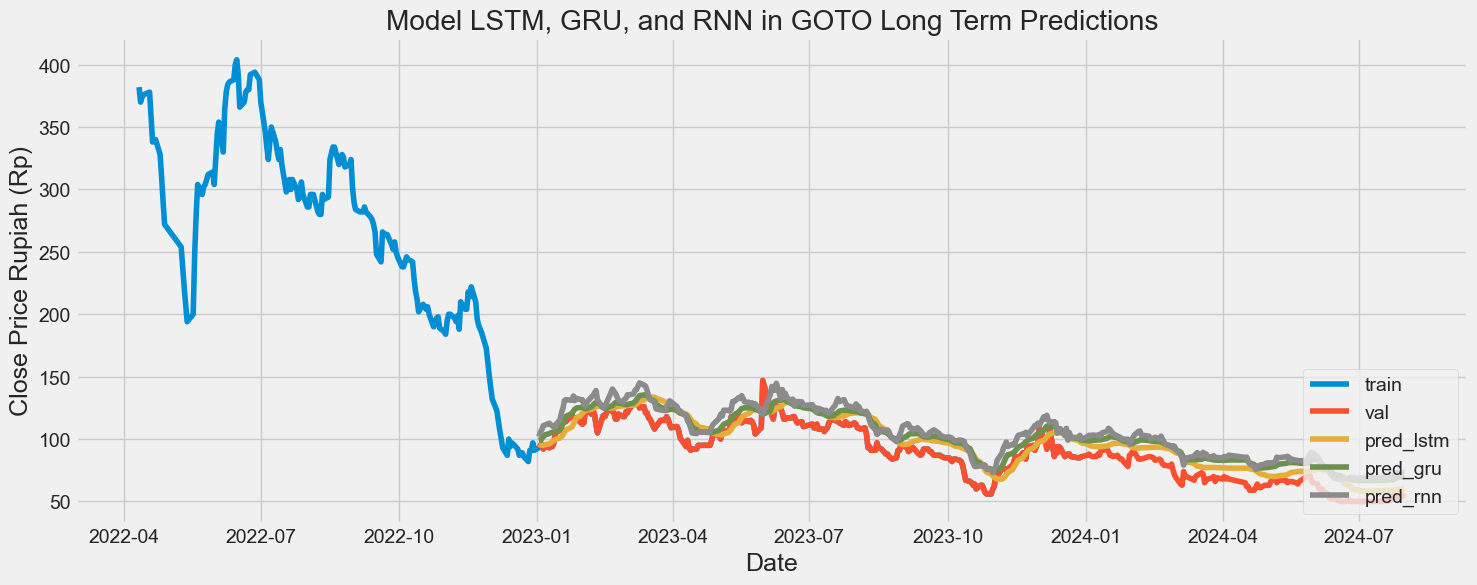

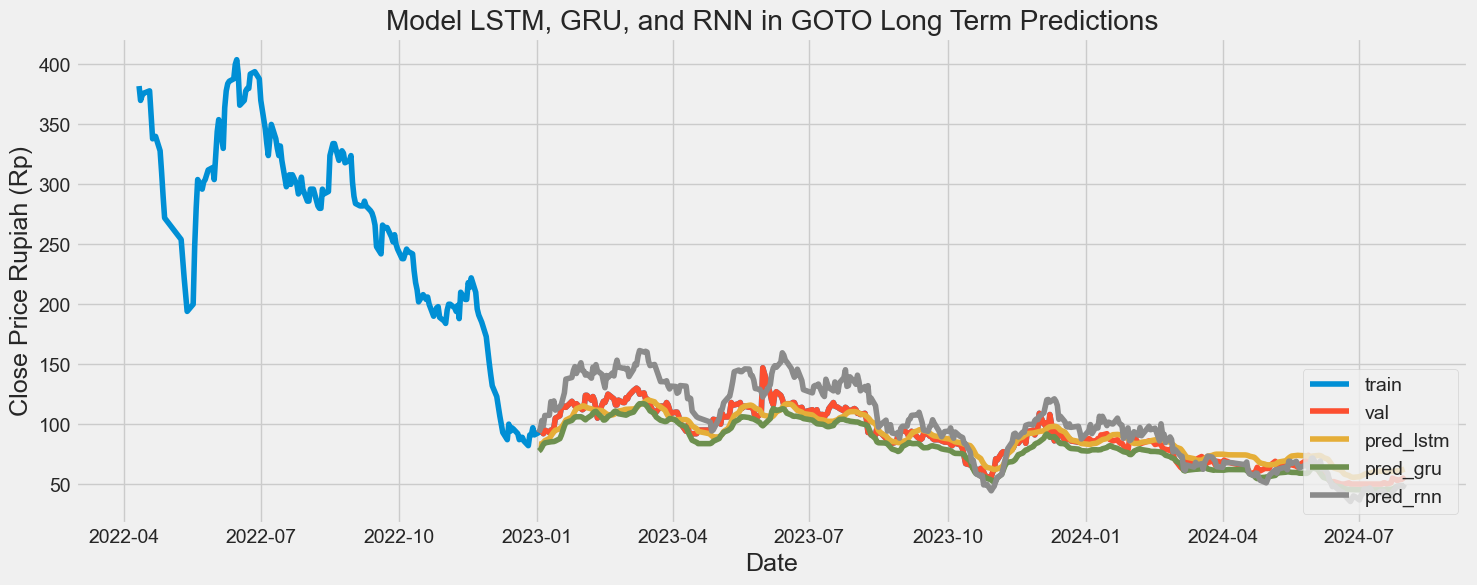

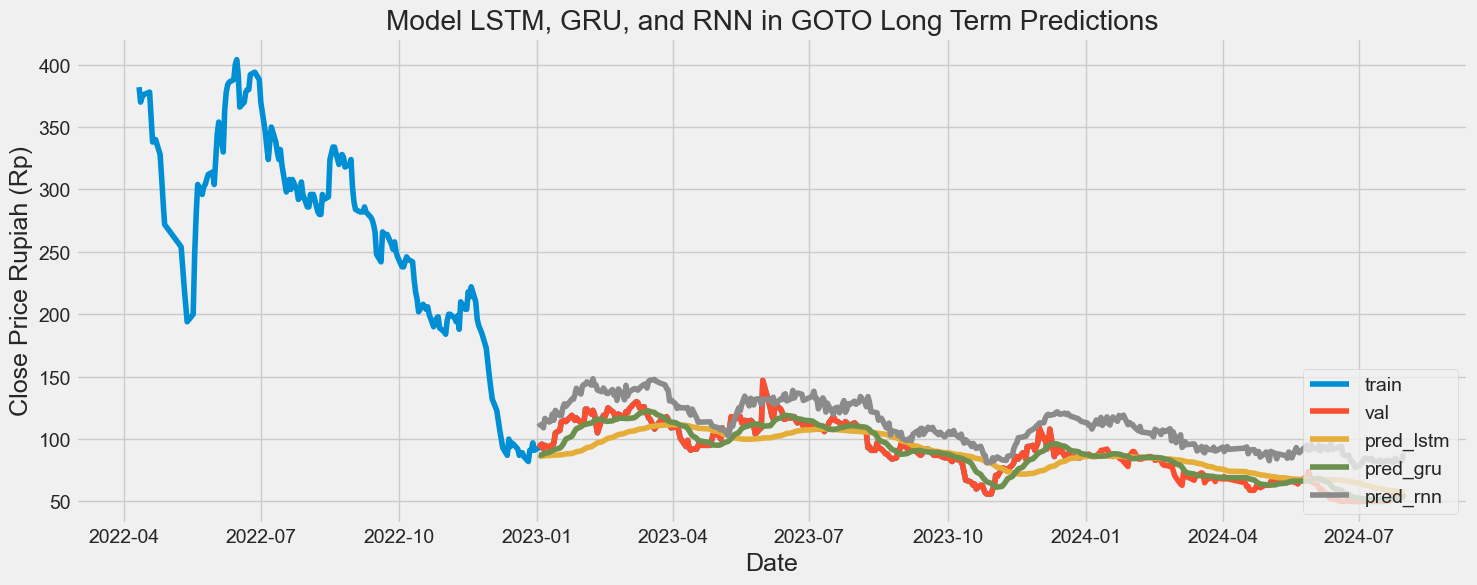

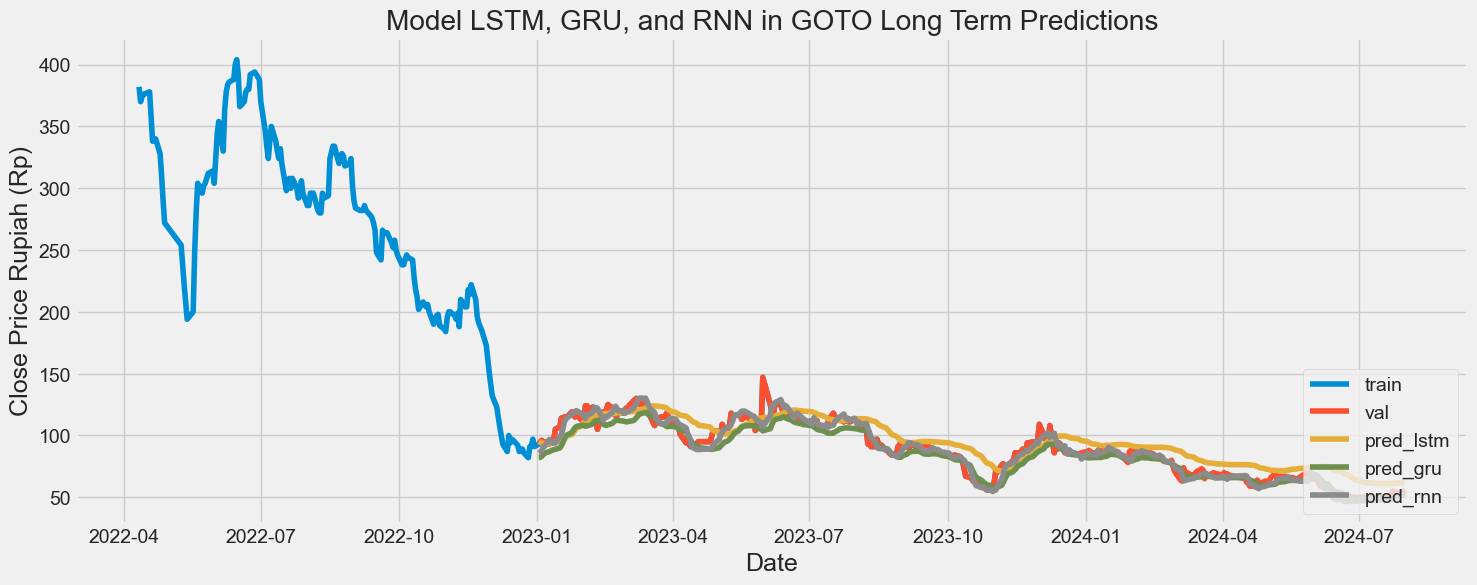

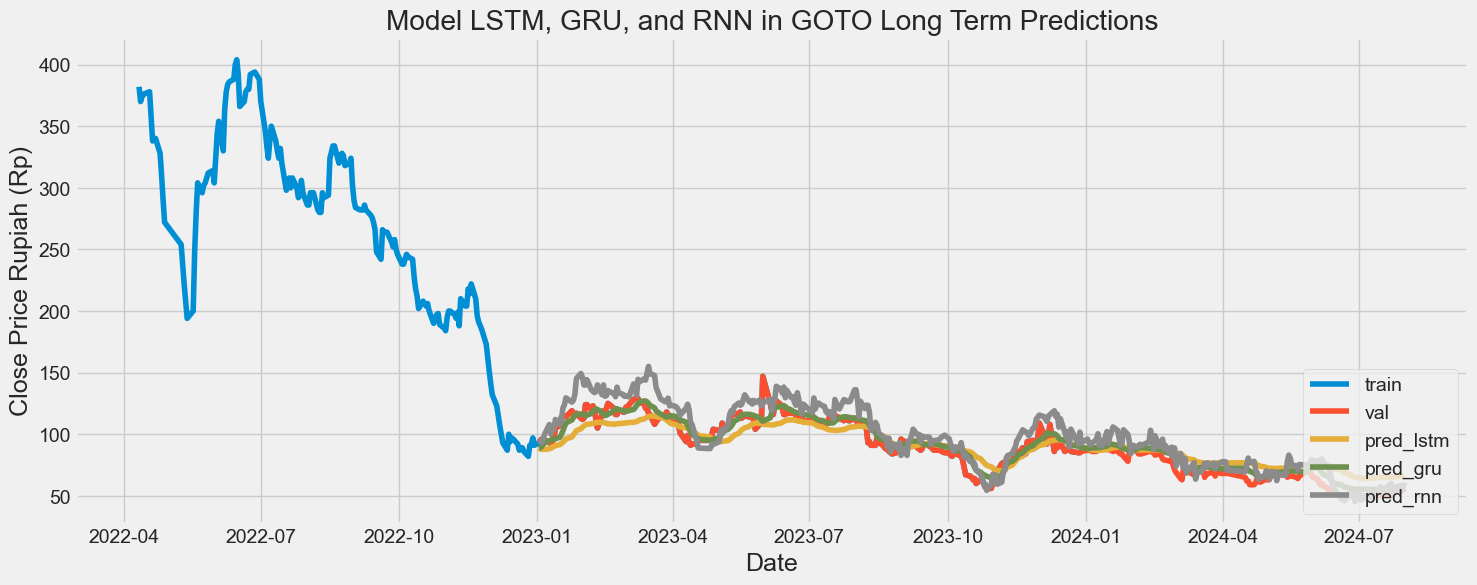

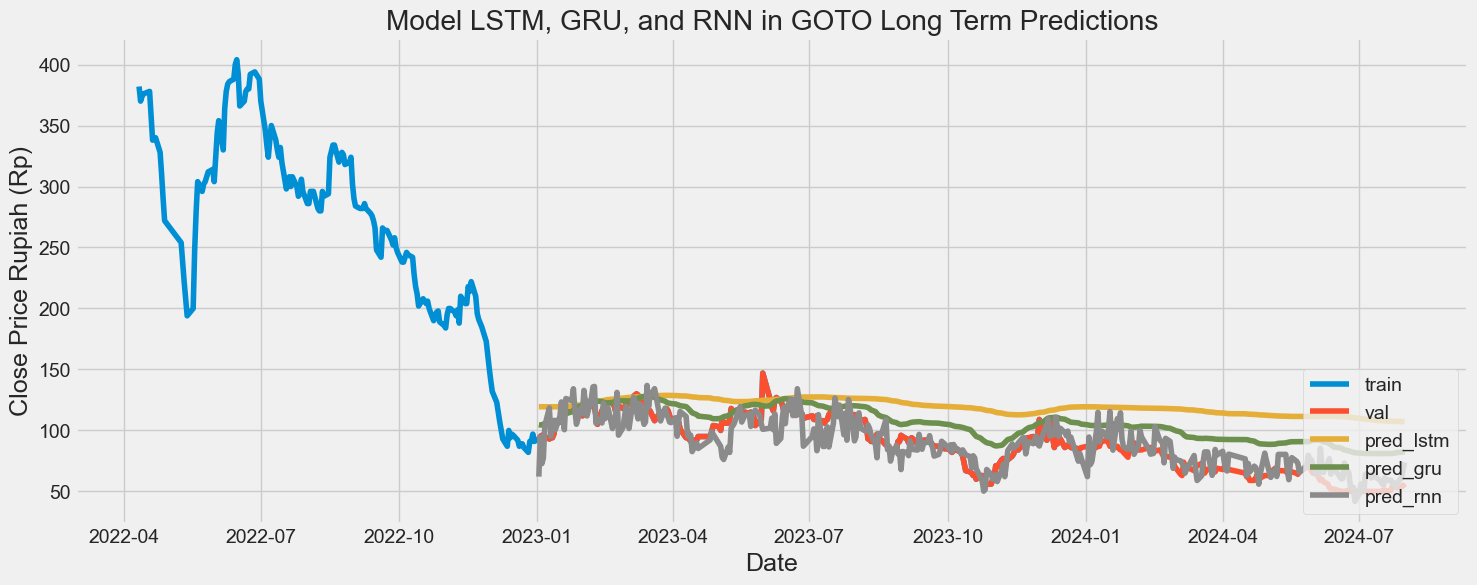

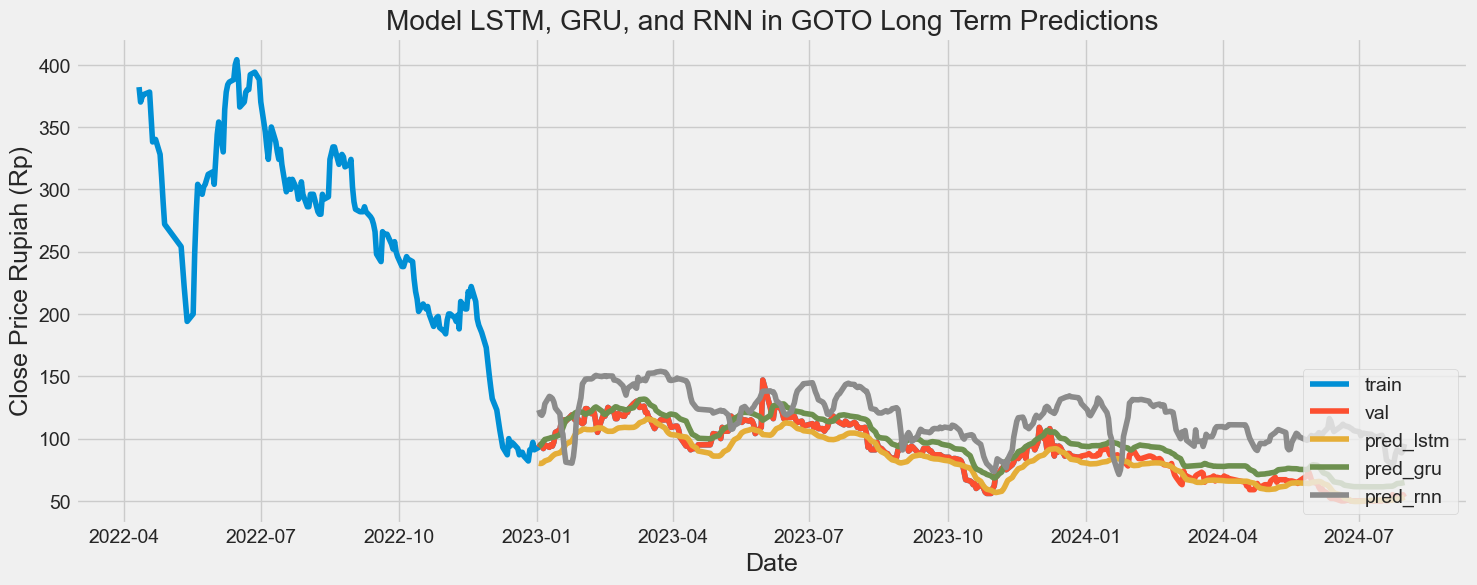

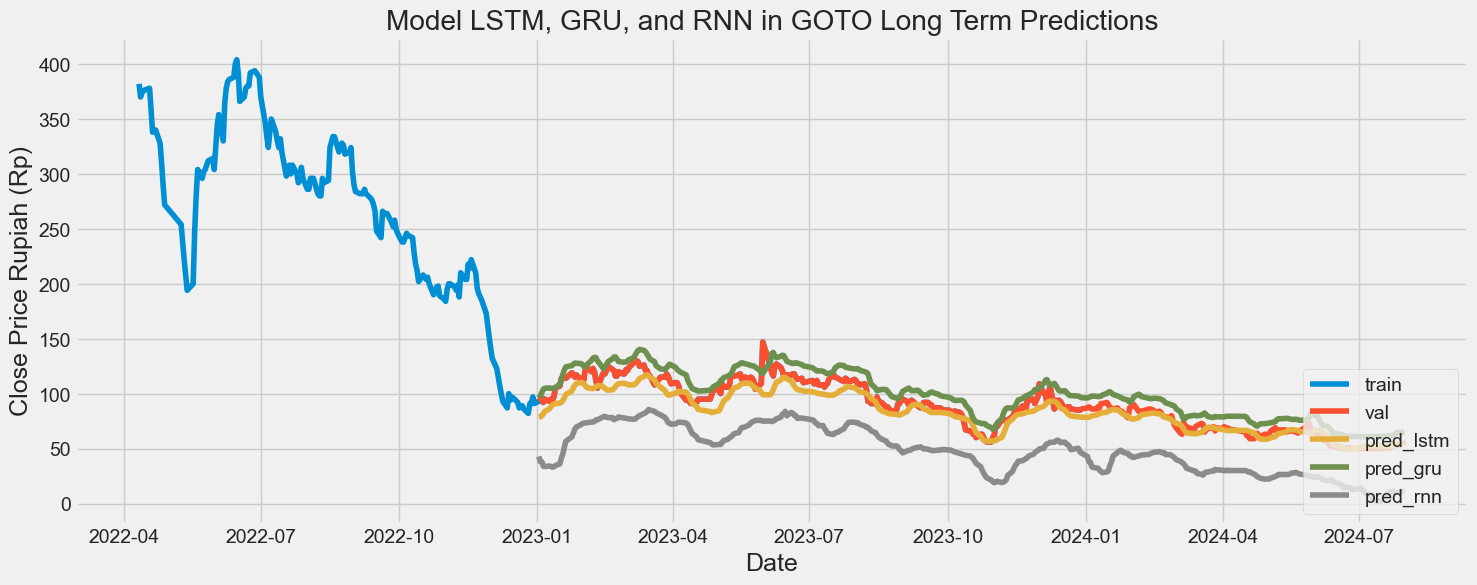

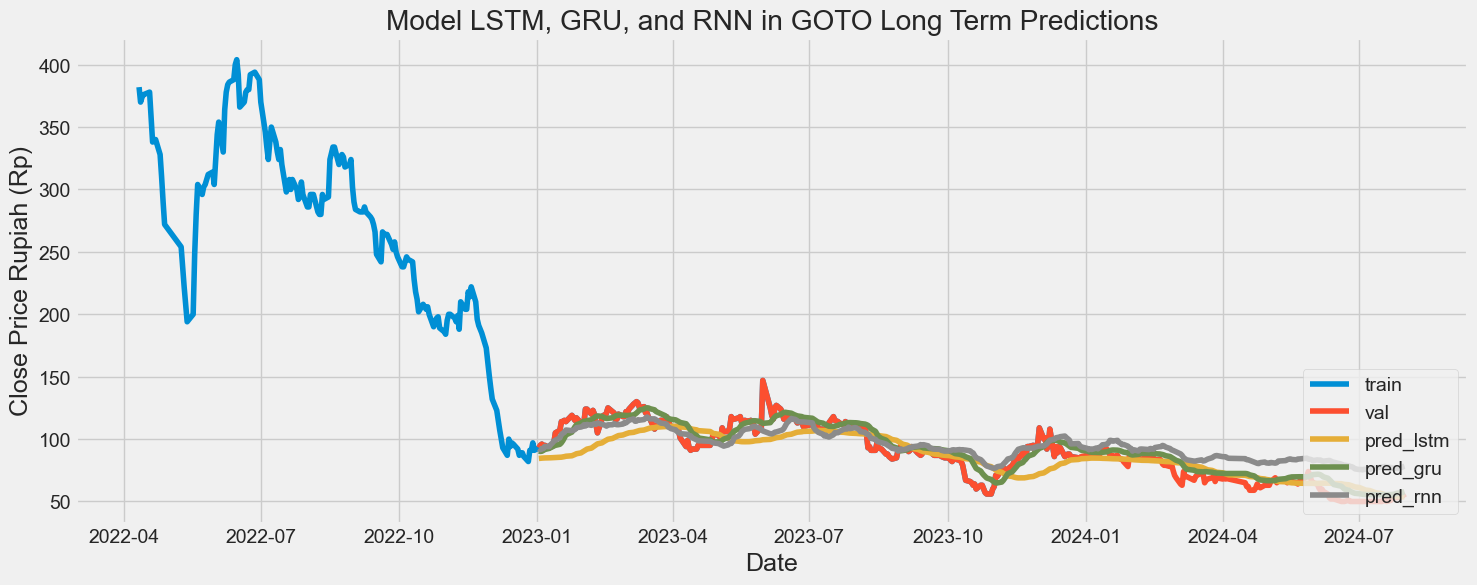

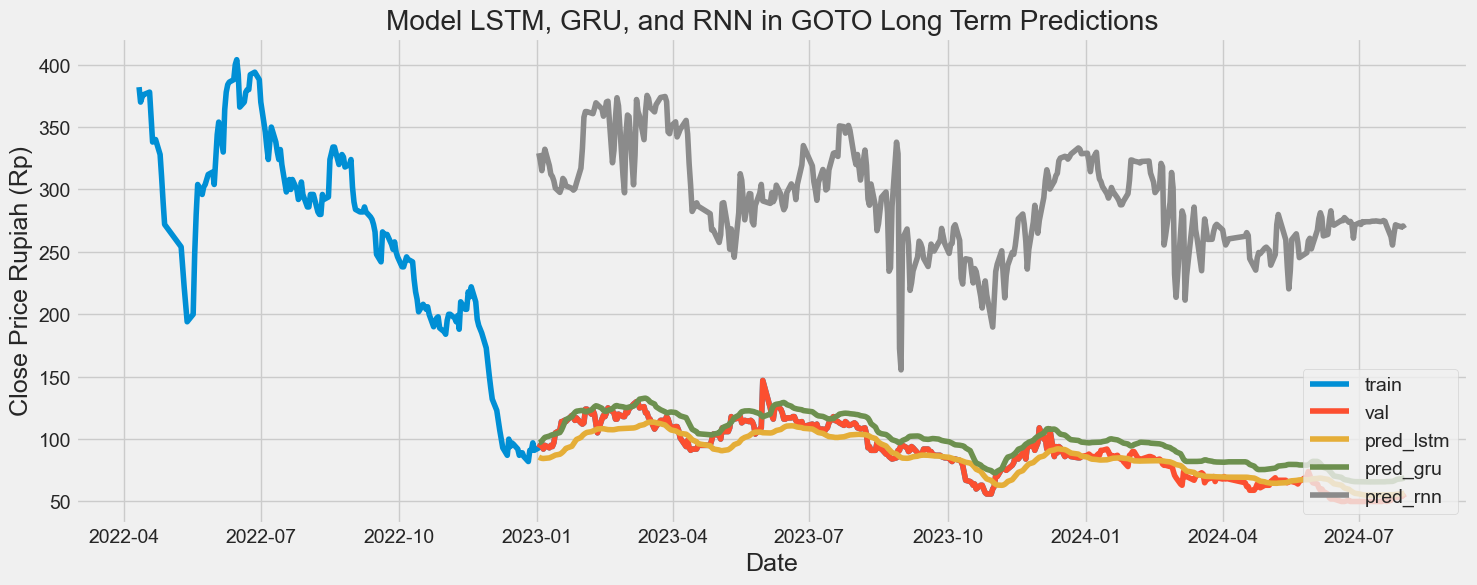

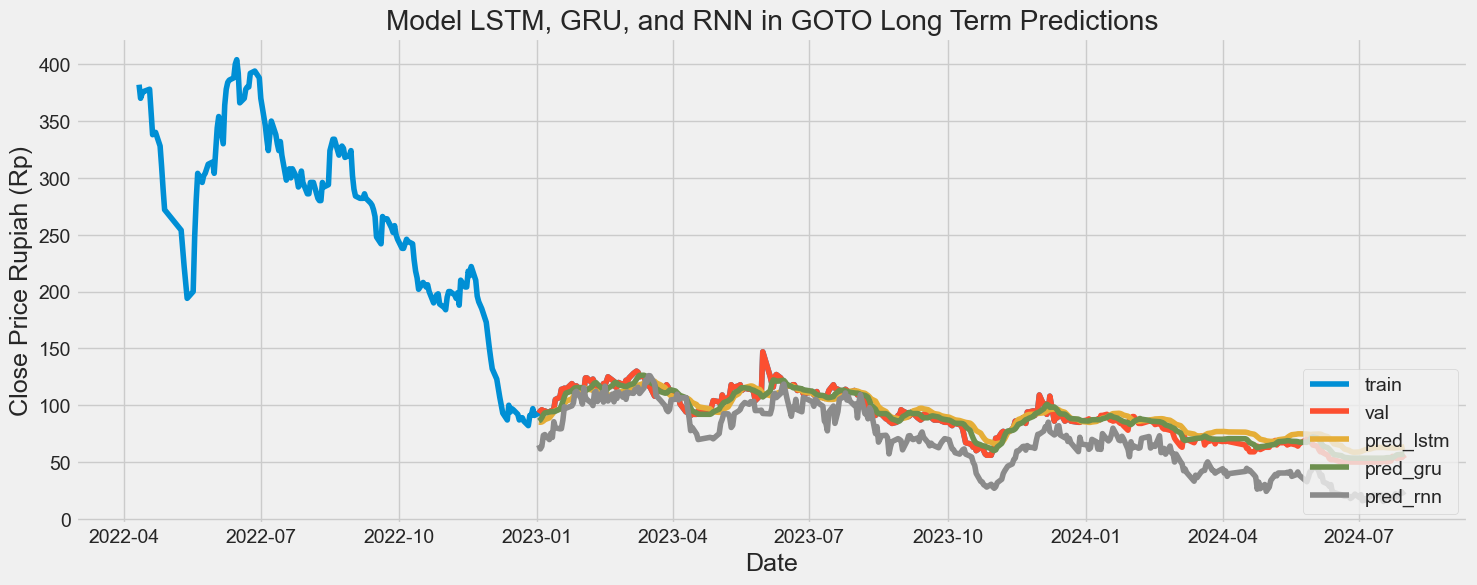

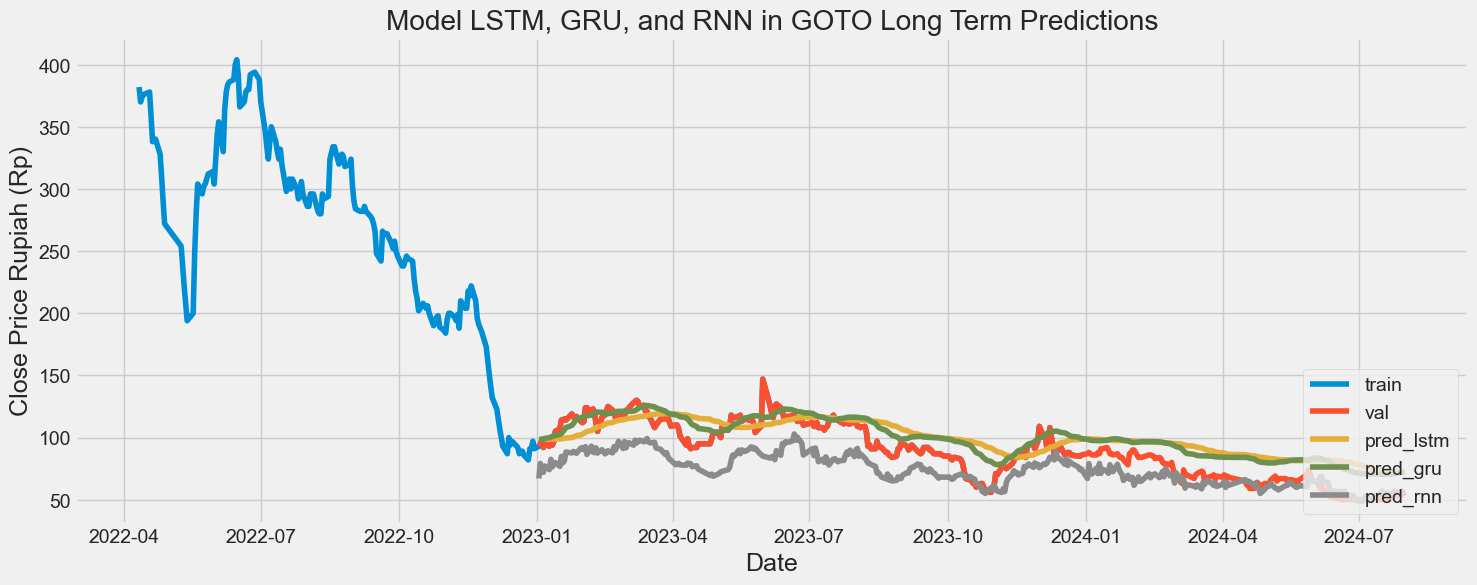

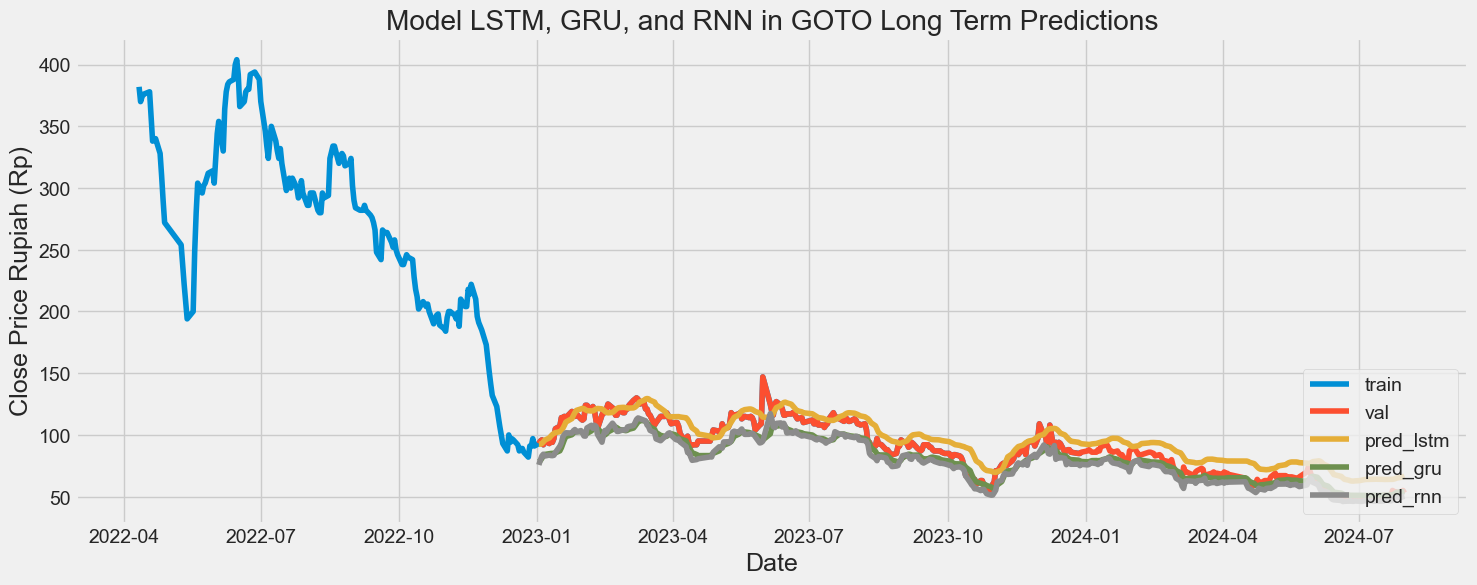

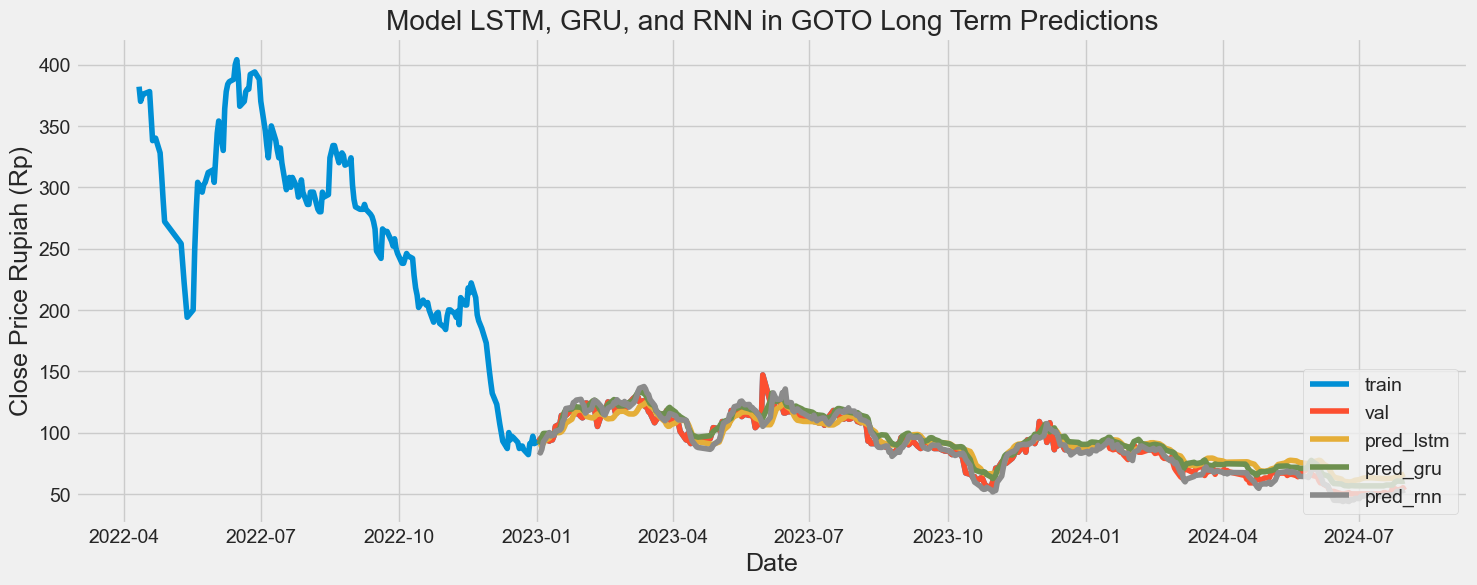

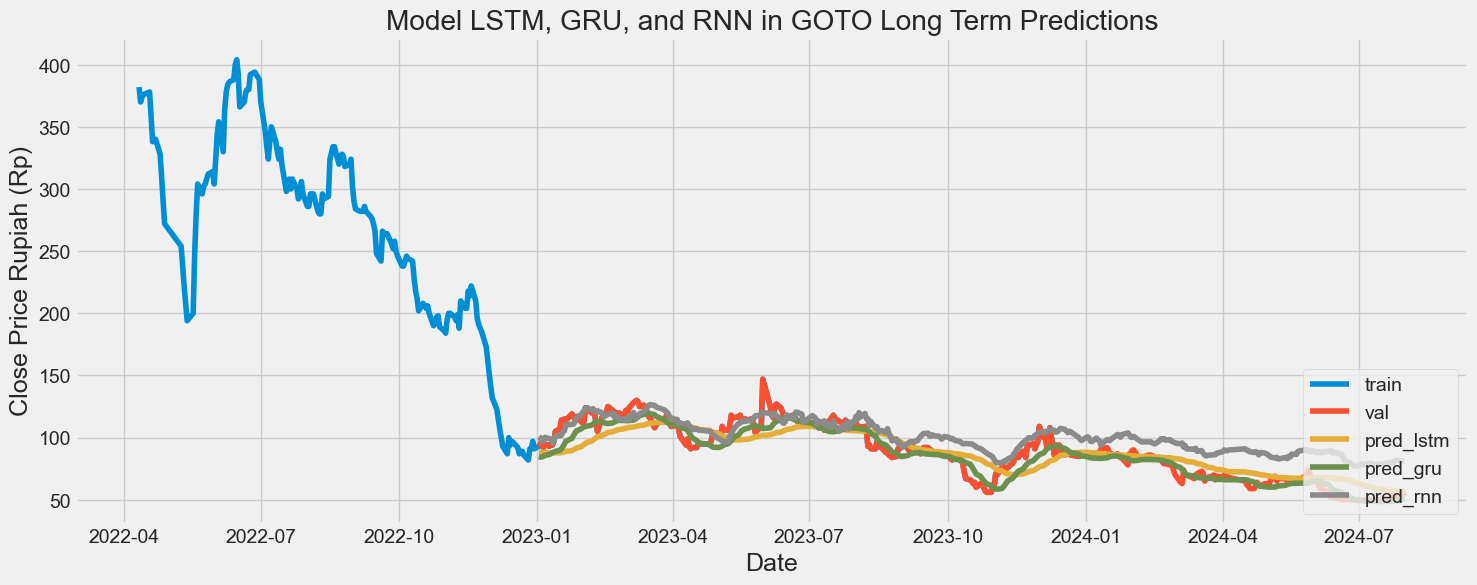

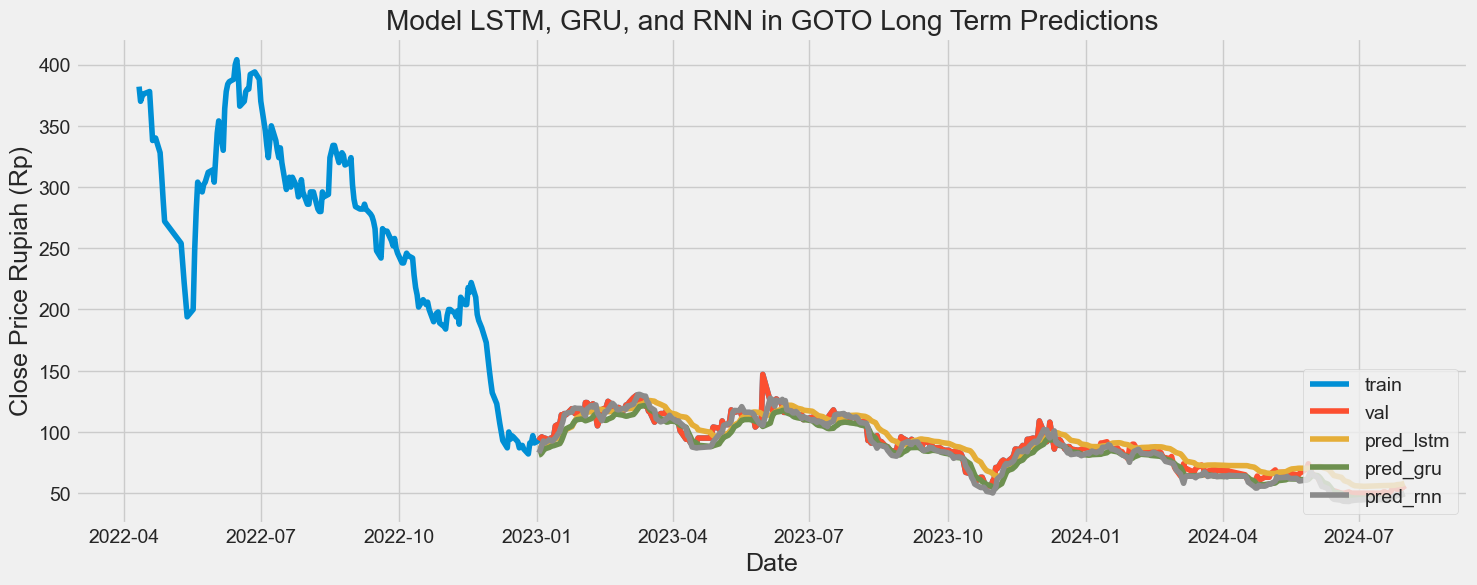

In [14]:
stock_name = ['GOTO']
try_epoch = [50, 100]
try_batch = [32, 64]
try_unit = [50, 100]
try_optimizer = ['rmsprop', 'adam', 'sgd']
for n_name in stock_name:
    if n_name == 'GOTO':
        n_data = GOTO
    elif n_name == 'ASII':
        n_data = ASII
    for n_epoch in try_epoch:
        for n_unit in try_unit:
            for n_batch_size in try_batch:
                for n_optimizer in try_optimizer:
                    train_long(n_data, n_name, year, n_epoch, n_unit, n_batch_size, n_optimizer)
                